In [1]:
# Peter Nelson 30/9/19
# Code for use at the FASTBLADE facility, determining where to place hydraulic rams to best simulate desired loading on 
# test specimen. Desired loading distribution is integrated to give target shear and bending distributions. A dual 
# annealing SciPy solver is implemented to minimise an objective function describing the discrepancy between the target
# and achieved shear distributions. Upper and Lower Bounds can be specified as required.

# Start

In [2]:
import pandas as pd
import numpy as np

data = pd.read_excel(r"C:\Users\Peter's 2nd Laptop\Documents\MATLAB\FB again\Matlab Code No Contraints\testdata.xlsx")

number_rams = 4
nodes = 50
lower_b = 0.1
upper_b = 0.95

# Interpolation

In [3]:
L = data['radial position'][len(data)-1]

x = list(range(0,nodes))
b = L/(nodes-1)
x[:] = [ __ * b for __ in x]

Fx = np.interp(x,data['radial position'],data['Fx'])

# Defining Targets

In [4]:
import scipy, numpy 
from scipy import integrate

integralpart = scipy.integrate.cumtrapz(Fx, x)
integralpart = np.insert(integralpart,0,0)
TF = integralpart[-1]

TargetShear = [None]*len(Fx)
TargetShear[0] = TF
    
for k in range(1,len(integralpart)):
    TargetShear[k] = TF-integralpart[k]

integralPart = scipy.integrate.cumtrapz(TargetShear,x)
integralPart = numpy.insert(integralPart,0,0)
bmax = integralPart[-1]

TargetBending = [None]*len(Fx)
TargetBending[0] = -bmax

for k in range(1,len(integralPart)):
    TargetBending[k] = integralPart[k]-bmax
    
F = TF/number_rams

# Actual Shear & Bending

In [5]:
def AcSh(sol):
    
    if sol[-1] != L:
        sol = np.append(sol,L)
    
    ActualShear = [TF]*len(x)

    for i in range(0,len(x)):
        for j in range(0,len(sol)-1):
            if x[i] > sol[j]:
                ActualShear[i] = ActualShear[i]-F

    return(ActualShear)

In [6]:
def AcBe(AcSh):
    ActualShear = AcSh
    
    integralPart = scipy.integrate.cumtrapz(ActualShear,x)
    integralPart = numpy.insert(integralPart,0,0)
    bmax = integralPart[-1]
    
    ActualBending = [None]*len(Fx)
    ActualBending[0] = -bmax

    for k in range(1,len(integralPart)):
        ActualBending[k] = integralPart[k]-bmax
    
    return(ActualBending)

# Objective Function

In [7]:
def obj(sol):
    
    if len(sol) != number_rams:
        print('wrong number of rams')
        
    else:          
    
        lsq_l = [None]*(len(x))
        ActualShear = AcSh(sol)
        for i in range(0,len(x)):
            lsq_l[i] = abs(ActualShear[i]-TargetShear[i])
        return sum(lsq_l)

# Solver

In [10]:
bounds = [(lower_b*L, upper_b*L)]*number_rams
solfinal = scipy.optimize.dual_annealing(obj,bounds)  # consider random state since same obj func found
n = np.sort(solfinal.x)
print(n)

[ 800.80771904 1742.34550381 3203.73990257 5119.06094863]


# Results

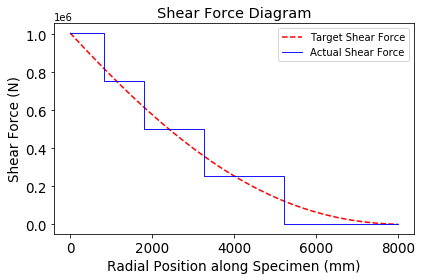

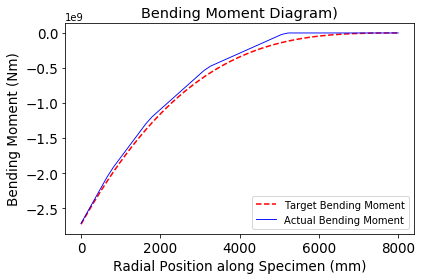

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline  

ActualShear = AcSh(n)
ActualBending = AcBe(ActualShear)

size=13.5

plt.plot(x, TargetShear,'r', label = 'Target Shear Force',ls='--')
plt.step(x, ActualShear, 'b', label = 'Actual Shear Force', where='post',lw=0.9)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Radial Position along Specimen (mm)',fontsize=size)
plt.ylabel('Shear Force (N)',fontsize=size)
plt.title('Shear Force Diagram',fontsize=size+1)
plt.tick_params(axis='both', which='major', labelsize=13.5)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('ShearForceDiagram_bounds.png')
plt.show()

plt.plot(x,TargetBending, 'r', label = 'Target Bending Moment',ls='--')
plt.plot(x, ActualBending, 'b', label = 'Actual Bending Moment',lw=0.9)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel('Radial Position along Specimen (mm)',fontsize=size)
plt.ylabel('Bending Moment (Nm)',fontsize=size)
plt.tick_params(axis='both', which='major', labelsize=13.5)
plt.title('Bending Moment Diagram)',fontsize=size+1, y=1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('BendingMomentDiagram_bounds.png')
plt.show()